Camera Calibration with OpenCV
===

### Run the code in the cell below to extract object points and image points for camera calibration.  

In [1]:
import pickle
import matplotlib.pyplot as plt
import numpy as np
import cv2
import glob
import os

In [2]:
class cameraInfo:
    def __init__(self, camera_number):
        self.camera_number = camera_number
        self.chessboard_size = None
        self.objpoints = []
        self.imgpoints = []
        self.mtx = None
        self.dist = None
        self.rvecs = None
        self.tvecs = None

In [3]:
# Set the dimensions of the chessboard for every camera
all_chessboard_sizes = [(5, 7), (5, 7), (5, 7), (5, 7), (6, 9), (6, 9), (5, 7), (6, 9), (0, 0), (0, 0), (0, 0), (5, 7), (5, 7)]

# Ask to the user which cameras he wants to calibrate
cameras = input("Which cameras do you want to calibrate? (1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, all) ")
cameras = cameras.split(", ")
if cameras == ['all']:
    cameras = list(range(1, 14))
else:
    cameras = [int(i) for i in cameras]
    
cameras = [i for i in cameras if i not in [9, 10, 11]] # Comment this line if you want to calibrate cameras 9, 10, 11 (not available)
#print(cameras)

# Create a list of cameraInfo objects
cameras_info = []
for camera_number in cameras:
    cameras_info.append(cameraInfo(camera_number))
    cameras_info[-1].chessboard_size = all_chessboard_sizes[camera_number - 1]
# Print all the chessboard sizes for the selected cameras
print("Selected cameras info:")
for camera in cameras_info:
    print("Camera " + str(camera.camera_number) + ": " + str(camera.chessboard_size))




Selected cameras info:
Camera 1: (5, 7)


In [4]:
for camera in cameras_info:    
    # Define chessboard dimensions
    CHESS_WIDTH = camera.chessboard_size[0]
    CHESS_HEIGHT = camera.chessboard_size[1]
    VIDEO_NAME = 'out' + str(camera.camera_number) + 'F'

    # prepare object points, like (0,0,0), (1,0,0), (2,0,0), ...(6,5,0)
    objp = np.zeros((CHESS_WIDTH * CHESS_HEIGHT, 3), np.float32)
    objp[:, :2] = np.mgrid[0:CHESS_WIDTH, 0:CHESS_HEIGHT].T.reshape(-1, 2)

    # Arrays to store object points and image points from all the images.
    camera.objpoints = []  # 3d point in real world space
    camera.imgpoints = []  # 2d points in image plane.

    # Open the video file
    video_capture = cv2.VideoCapture('video/' + VIDEO_NAME + '.mp4')

    # Set the frame skip interval (1 frame every 30)
    frame_skip = 15

    frame_count = 0
    new_resolution = (1920, 1080)

    # Termination criteria for the iterative algorithm
    termination_criteria = (cv2.TERM_CRITERIA_EPS +
                            cv2.TERM_CRITERIA_MAX_ITER, 30, 0.001)

    # Print the number of frames in the video
    numberOf_frame = int(video_capture.get(cv2.CAP_PROP_FRAME_COUNT))
    print("Number of frames in the video: ", numberOf_frame)

    # Create a directory to save the screen captures named as the video file
    output_dir = 'samples/' + VIDEO_NAME
    os.makedirs(output_dir, exist_ok=True)
    print("Saving frames to ", output_dir)
    # Remove all files in the directory
    for file in os.listdir(output_dir):
        os.remove(os.path.join(output_dir, file))

    # Dictionary to keep track of the number of frames saved for each quadrant
    quadrant_frame_count = {0: 0, 1: 0, 2: 0, 3: 0}

    while True:
        # Read a frame from the video
        ret, img = video_capture.read()
        if not ret:
            break  # Break the loop if we've reached the end of the video

        # Skip frames based on the frame_skip value
        if frame_count % frame_skip == 0:
            # Resize the frame to the new_resolution
            real_img = img
            img = cv2.resize(img, new_resolution)
            gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

            # Find the chessboard corners
            found_corners, corners = cv2.findChessboardCorners(gray, (CHESS_WIDTH, CHESS_HEIGHT), None)
            #print("Frame ", frame_count, ":", found_corners)

            # If found, add object points, image points, and save frames for each quadrant
            if found_corners:
                # Determine which quadrant the chessboard is in
                width_half = new_resolution[0] // 2
                height_half = new_resolution[1] // 2
                quadrant = 0  # 0: Top-left, 1: Top-right, 2: Bottom-left, 3: Bottom-right

                if corners[0][0][0] < width_half:
                    if corners[0][0][1] < height_half:
                        quadrant = 0
                    else:
                        quadrant = 2
                else:
                    if corners[0][0][1] < height_half:
                        quadrant = 1
                    else:
                        quadrant = 3

                # Check if we've saved 5 frames for this quadrant, if not, save the frame
                if quadrant_frame_count[quadrant] < 5:
                    frame_skip = 15
                    frame_filename = os.path.join(output_dir, f"quadrant_{quadrant}_frame_{quadrant_frame_count[quadrant]}.jpg")
                    cv2.imwrite(frame_filename, img)
                    #save also the real image
                    frame_filename = os.path.join(output_dir, f"quadrant_{quadrant}_frame_{quadrant_frame_count[quadrant]}_real.jpg")
                    cv2.imwrite(frame_filename, real_img)
                    quadrant_frame_count[quadrant] += 1
                    camera.objpoints.append(objp)  # 3D point in real-world space
                    camera.imgpoints.append(corners)
                    print("Saved frame ", frame_count, " for quadrant ", quadrant)
                else:
                    frame_skip = 50
                    print("Already saved 5 frames for quadrant ", quadrant)
                    print("Skipping frame ", frame_count)
                # Draw and display the corners (optional)
                #cv2.drawChessboardCorners(img, (CHESS_WIDTH, CHESS_HEIGHT), corners, found_corners)
            else:
                frame_skip = 50
                print("No corners found in frame ", frame_count)
                
            

        frame_count += 1

        # Check if we've saved enough frames for all quadrants
        if all(count >= 5 for count in quadrant_frame_count.values()):
            #print("Camera", camera.camera_number, "done!")
            break

    video_capture.release()
    cv2.destroyAllWindows()
    print("Camera", camera.camera_number, "done!")


Number of frames in the video:  2584
Saving frames to  samples/out1F
No corners found in frame  0
No corners found in frame  50
No corners found in frame  100
No corners found in frame  150
No corners found in frame  200
No corners found in frame  250
No corners found in frame  300
No corners found in frame  350
No corners found in frame  400
No corners found in frame  450
Saved frame  500  for quadrant  2
Saved frame  510  for quadrant  2
Saved frame  525  for quadrant  0
Saved frame  540  for quadrant  0
Saved frame  555  for quadrant  2
Saved frame  570  for quadrant  2
Saved frame  585  for quadrant  0
Saved frame  600  for quadrant  0
Saved frame  615  for quadrant  0
Already saved 5 frames for quadrant  0
Skipping frame  630
Already saved 5 frames for quadrant  0
Skipping frame  650
Saved frame  700  for quadrant  1
Saved frame  705  for quadrant  1
Saved frame  720  for quadrant  1
Saved frame  735  for quadrant  1
Saved frame  750  for quadrant  1
Already saved 5 frames for qua

### If the above cell ran sucessfully, you should now have `objpoints` and `imgpoints` needed for camera calibration.  Run the cell below to calibrate, calculate distortion coefficients, and test undistortion on an image!

Testing undistortion on camera 1


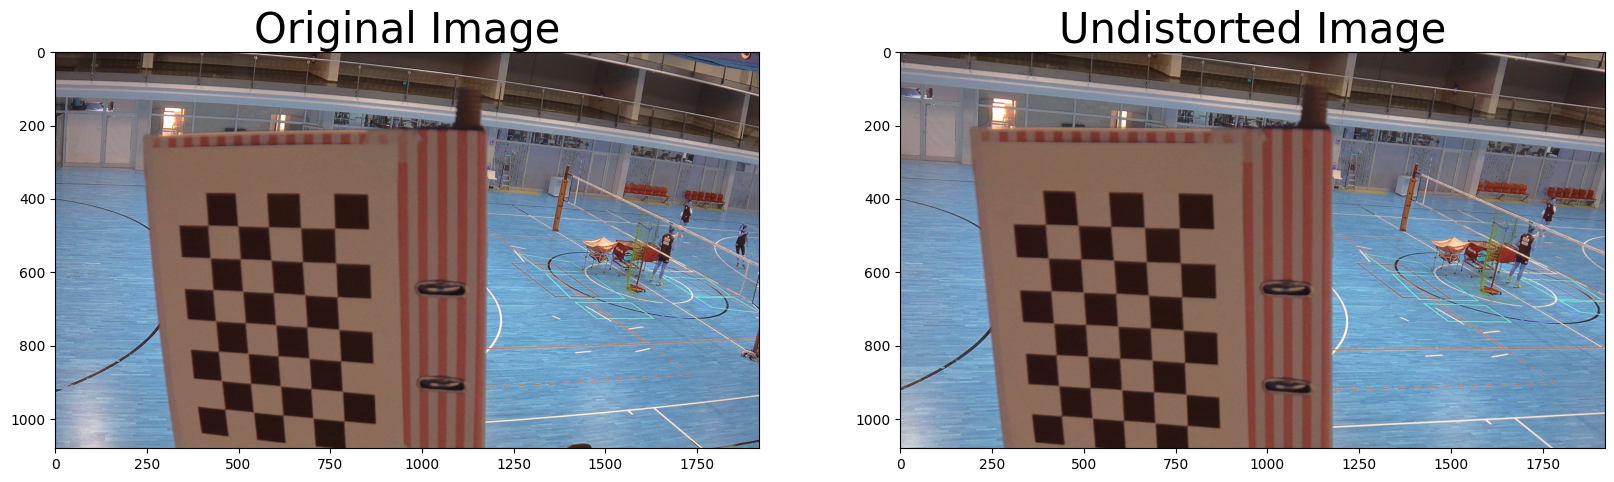

In [5]:

for camera in cameras_info:
    # Test undistortion on an image
    print("Testing undistortion on camera", camera.camera_number)
    img = cv2.imread('samples/' + 'out' + str(camera.camera_number) + 'F' + '/quadrant_0_frame_0.jpg')
    if img is None:
        print("Image not found")
        exit()
    img_size = (img.shape[1], img.shape[0])

    # Do camera calibration given object points and image points
    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(camera.objpoints, camera.imgpoints, img_size,None,None)

    #new camera matrix
    #new_mtx = cv2.getOptimalNewCameraMatrix(mtx, dist, img_size, 1, img_size)

    dst = cv2.undistort(img, mtx, dist, None, mtx)
    cv2.imwrite('output/undistorted_' + 'out' + str(camera.camera_number) + 'F' +'.jpg',dst)

    # Save the camera calibration result for later use (we won't worry about rvecs / tvecs)
    dist_pickle = {}
    dist_pickle["mtx"] = mtx
    dist_pickle["dist"] = dist
    pickle.dump( dist_pickle, open( "output/parameters_" + 'out' + str(camera.camera_number) + 'F' + ".p", "wb" ) )
    # Append to a txt file the parameters
    with open('output/parameters.txt', 'a') as f:
        f.write("Camera " + str(camera.camera_number) + "\n" + "\n" )
        f.write("mtx: " + str(mtx) + "\n")
        f.write("dist: " + str(dist) + "\n")
    # print("mtx: " + str(mtx) + "\n")
    # print("dist: " + str(dist) + "\n")

    # Visualize undistortion
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
    ax1.imshow(img)
    ax1.set_title('Original Image', fontsize=30)
    ax2.imshow(dst)
    ax2.set_title('Undistorted Image', fontsize=30)
    


# Calibration without cropping the image

Testing undistortion on camera 1


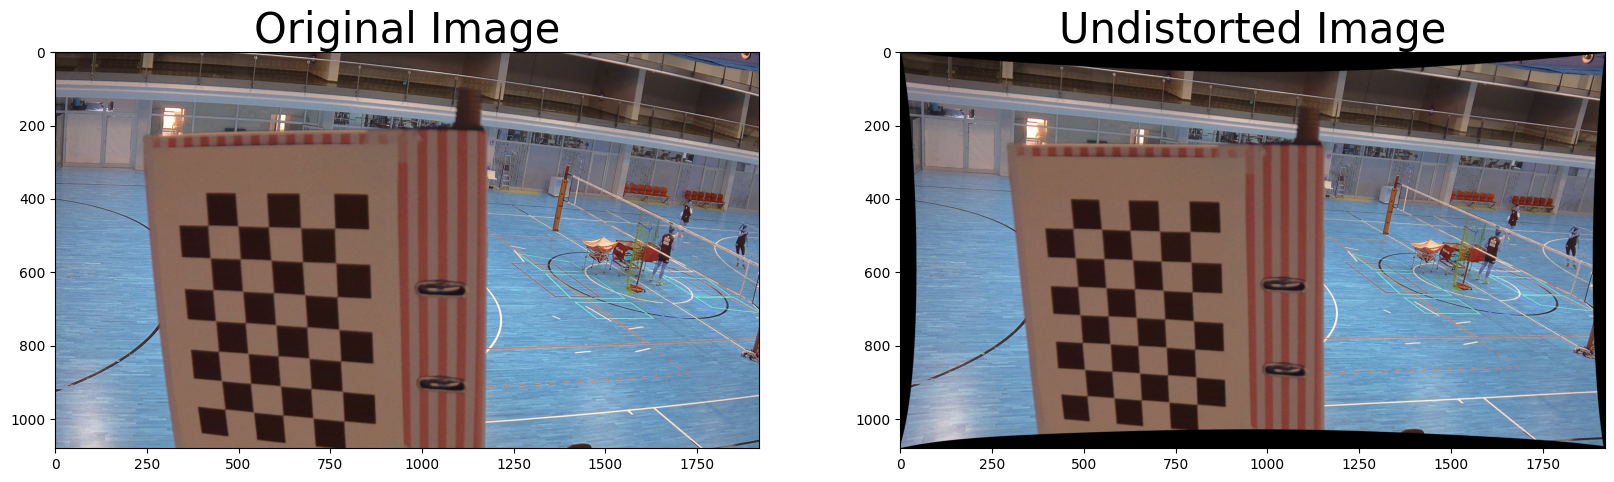

In [6]:

for camera in cameras_info:
    # Test undistortion on an image
    print("Testing undistortion on camera", camera.camera_number)
    img = cv2.imread('samples/' + 'out' + str(camera.camera_number) + 'F' + '/quadrant_0_frame_0.jpg')
    if img is None:
        print("Image not found")
        exit()
    img_size = (img.shape[1], img.shape[0])

    # Do camera calibration given object points and image points
    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(camera.objpoints, camera.imgpoints, img_size,None,None)

    #new camera matrix
    new_mtx, roi = cv2.getOptimalNewCameraMatrix(mtx, dist, img_size, 1, img_size)

    dst = cv2.undistort(img, mtx, dist, None, new_mtx)
    cv2.imwrite('output/undistorted_' + 'out' + str(camera.camera_number) + 'F' +'.jpg',dst)

    # Save the camera calibration result for later use (we won't worry about rvecs / tvecs)
    dist_pickle = {}
    dist_pickle["mtx"] = mtx
    dist_pickle["dist"] = dist
    pickle.dump( dist_pickle, open( "output/parameters_" + 'out' + str(camera.camera_number) + 'F' + ".p", "wb" ) )
    # Append to a txt file the parameters
    with open('output/parameters.txt', 'a') as f:
        f.write("Camera " + str(camera.camera_number) + "\n" + "\n" )
        f.write("mtx: " + str(mtx) + "\n")
        f.write("dist: " + str(dist) + "\n")
    # print("mtx: " + str(mtx) + "\n")
    # print("dist: " + str(dist) + "\n")

    # Visualize undistortion
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
    ax1.imshow(img)
    ax1.set_title('Original Image', fontsize=30)
    ax2.imshow(dst)
    ax2.set_title('Undistorted Image', fontsize=30)
    


Testing undistortion on camera 1


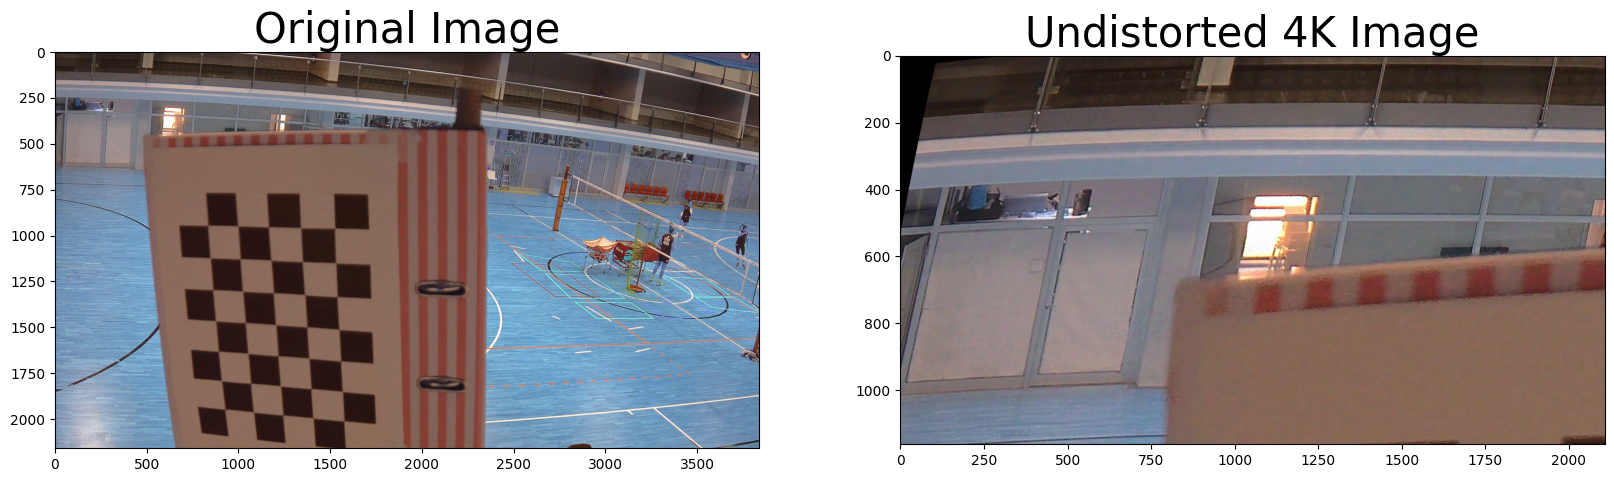

In [7]:
# Supponiamo che 'cameras_info' sia la tua lista di informazioni sulla telecamera

# Rapporto di scala tra 1080p e 4K (3840x2160)
scala = 3840 / 1920

for camera in cameras_info:
    print("Testing undistortion on camera", camera.camera_number)
    img = cv2.imread('samples/' + 'out' + str(camera.camera_number) + 'F' + '/quadrant_0_frame_0_real.jpg')
    if img is None:
        print("Image not found")
        exit()
    img_size = (img.shape[1], img.shape[0])

    # Do camera calibration given object points and image points
    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(camera.objpoints, camera.imgpoints, img_size, None, None)

    # Nuova matrice della telecamera per 4K
    mtx_4k = mtx.copy()
    mtx_4k[0, 0] *= scala  # fx
    mtx_4k[1, 1] *= scala  # fy
    mtx_4k[0, 2] *= scala  # cx
    mtx_4k[1, 2] *= scala  # cy


    # Adatta la matrice di distorsione per 4K (la matrice di distorsione non viene influenzata dal rapporto di scala)
    dist_4k = dist.copy()

    # Undistorsione dell'immagine 4K
    dst_4k = cv2.undistort(img, mtx, dist, None, mtx_4k)

    # Ritaglia l'immagine per rimuovere le aree nere ai bordi
    new_mtx, roi = cv2.getOptimalNewCameraMatrix(mtx, dist, img_size, 1, img_size)
    x, y, w, h = roi
    dst_4k = dst_4k[y:y+h, x:x+w]

    # Salvare l'immagine undistorsa 4K
    cv2.imwrite('output/undistorted_4k_' + 'out' + str(camera.camera_number) + 'F' + '.jpg', dst_4k)

    # Salvare i parametri della telecamera 4K
    dist_pickle_4k = {}
    dist_pickle_4k["mtx"] = mtx_4k
    dist_pickle_4k["dist"] = dist_4k
    pickle.dump(dist_pickle_4k, open("output/parameters_4k_" + 'out' + str(camera.camera_number) + 'F' + ".p", "wb"))

    # Visualizzare l'immagine originale e quella undistorsa 4K
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))
    ax1.imshow(img)
    ax1.set_title('Original Image', fontsize=30)
    ax2.imshow(dst_4k)
    ax2.set_title('Undistorted 4K Image', fontsize=30)

    # Mostrare le immagini
    plt.show()
